In [2]:
from IPython.parallel import Client
c = Client(profile='parallel_python2.7')
dview = c.direct_view()
lview = c.load_balanced_view()

In [84]:
import os.path
import sstanalysis
print os.path.abspath(sstanalysis.__file__)

import os
import inspect
print inspect.getfile(sstanalysis)

import sstanalysis
print sstanalysis.__path__

/home/takaya/sst_analysis/sstanalysis/__init__.pyc
sstanalysis/__init__.pyc
['sstanalysis']


In [18]:
import numpy as np
from scipy import io
from sstanalysis import gfd
from scipy import interpolate as naiso
from matplotlib import pyplot as plt
%matplotlib inline

with dview.sync_imports():
    import numpy
    import os
    import netCDF4
    import warnings
    from scipy import io
    from scipy import interpolate
    from matplotlib import pyplot
    from scipy import linalg
    from scipy import signal
    from scipy import fftpack
    from warnings import warn
    #from sstanalysis import popmodel

importing numpy on engine(s)
importing os on engine(s)
importing netCDF4 on engine(s)
importing warnings on engine(s)
importing io from scipy on engine(s)
importing interpolate from scipy on engine(s)
importing pyplot from matplotlib on engine(s)
importing linalg from scipy on engine(s)
importing signal from scipy on engine(s)
importing fftpack from scipy on engine(s)
importing warn from warnings on engine(s)


In [4]:
%%px --local
print 'Hello from engines AND client'

Hello from engines AND client
[stdout:0] Hello from engines AND client
[stdout:1] Hello from engines AND client
[stdout:2] Hello from engines AND client
[stdout:3] Hello from engines AND client


In [5]:
dlat, dlon = (10., 10.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = np.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = np.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = np.meshgrid(lon_global, lat_global)
psd_slopes_Feb_global = np.zeros((Degy+1,Degx+1))
#psd_slopes_Aug_global = np.zeros((Degy+1,Degx+1))
psd_level_Feb_global = np.zeros((Degy+1,Degx+1))
#psd_level_Aug_global = np.zeros((Degy+1,Degx+1))
L_1_global = np.zeros((Degy+1,Degx+1)) 
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy, (Degx+1)*(Degy+1)
print Lon_global.shape

34 11 420
(13, 36)


In [6]:
roll = -1080

fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)
mask = f.variables['KMT'][:] <= 1
SSH = 1e-2*f.variables['SSH_2'][:]
tlon = np.roll(np.ma.masked_array(f.variables['TLONG'][:],mask), roll, axis=1)
tlat = np.roll(np.ma.masked_array(f.variables['TLAT'][:],mask), roll, axis=1)


lonrange=np.array([lon_start, lon_end])
latrange=np.array([lat_start, lat_end+5.])
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin_bound, imax_bound = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin_bound, jmax_bound = jrange.min(), jrange.max()

In [7]:
Nt, Ny, Nx = SSH.shape
Ny_full = jmax_bound+100-jmin_bound
Nx_full = imax_bound+100-imin_bound
SSH_full = np.ma.zeros((Nt*5, Ny_full, Nx_full))
SSH_masked = np.ma.zeros((Nt,Ny,Nx))

for yearnum in range(0,5):
    fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 % (1, yearnum+46))
    f = netCDF4.Dataset(fname)
    
    for i in range(Nt):
        SSH_masked[i] = 1e-2*np.roll(np.ma.masked_array(f.variables['SSH_2'][i],mask), roll, axis=1)
    
    SSH_full[Nt*yearnum:Nt*yearnum+Nt] = SSH_masked[:, jmin_bound:jmax_bound+100, imin_bound:imax_bound+100] 

In [8]:
DX = 1e-2*np.roll(np.ma.masked_array(f.variables['DXT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
DY = 1e-2*np.roll(np.ma.masked_array(f.variables['DYT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
tlon = np.roll(np.ma.masked_array(f.variables['TLONG'][:],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
tlat = np.roll(np.ma.masked_array(f.variables['TLAT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
mask_global = np.roll(mask, roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
tlon[tlon<0.] += 360.

In [9]:
Ny, Nx = tlon.shape
x = np.arange(0,Nx)
y = np.arange(0,Ny)
X,Y = np.meshgrid(x,y)
Zr = tlon.ravel()
Xr = np.ma.masked_array(X.ravel(), Zr.mask)
Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
Znew = Zr.data
Znew[Zr.mask] = Zm
Znew.shape = tlon.shape
tlon = Znew.copy()

Zr = tlat.ravel()
Xr = np.ma.masked_array(X.ravel(), Zr.mask)
Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
Znew = Zr.data
Znew[Zr.mask] = Zm
Znew.shape = tlat.shape
tlat = Znew.copy()

<matplotlib.colorbar.Colorbar instance at 0x7ff151c66128>

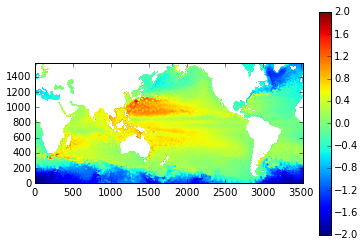

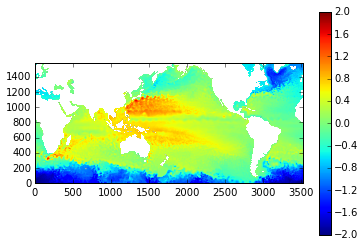

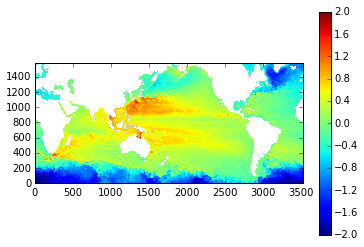

In [23]:
plt.figure()
plt.imshow(np.ma.masked_invalid(SSH_full[0]), origin='bottom')
plt.clim(-2.,2.)
plt.colorbar()

plt.figure()
plt.imshow(np.ma.masked_invalid(SSH_full[100]), origin='bottom')
plt.clim(-2.,2.)
plt.colorbar()

plt.figure()
plt.imshow(np.ma.masked_invalid(SSH_full[-1]), origin='bottom')
plt.clim(-2.,2.)
plt.colorbar()

In [10]:
Nt,Ny,Nx = SSH_full.shape
print Nt,Ny,Nx
SSH_flat = np.reshape(SSH_full.copy(), Nt*Ny*Nx)
N_flat = SSH_flat.shape[0]
print N_flat/4.

140 1578 3523
194575290.0


In [33]:
SSH_1 = SSH_flat[:N_flat/4]
SSH_2 = SSH_flat[N_flat/4:N_flat/2]
SSH_3 = SSH_flat[N_flat/2:3*N_flat/4]
SSH_4 = SSH_flat[3*N_flat/4:]

print SSH_1.shape, SSH_2.shape

(194575290,) (194575290,)


In [34]:
print N_flat/4./(Ny*Nx)*Nx*Ny
print SSH_1.shape[0]/(Ny*Nx)*Nx*Ny

SSH_1 = np.reshape(SSH_1,(SSH_1.shape[0]/(Ny*Nx),Ny,Nx))
SSH_2 = np.reshape(SSH_2,(SSH_2.shape[0]/(Ny*Nx),Ny,Nx))
SSH_3 = np.reshape(SSH_3,(SSH_3.shape[0]/(Ny*Nx),Ny,Nx))
SSH_4 = np.reshape(SSH_4,(SSH_4.shape[0]/(Ny*Nx),Ny,Nx))

194575290.0
194575290


<matplotlib.colorbar.Colorbar instance at 0x7ff15148be18>

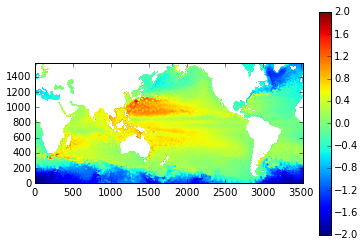

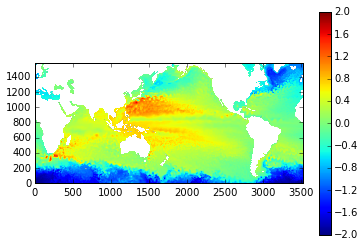

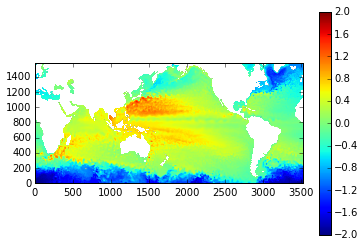

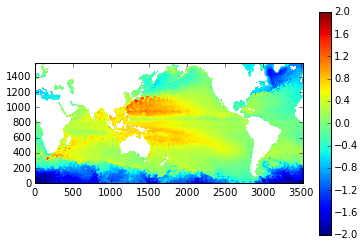

In [35]:
plt.figure()
plt.imshow(np.ma.masked_invalid(SSH_1[0]), origin='bottom')
plt.clim(-2.,2.)
plt.colorbar()

plt.figure()
plt.imshow(np.ma.masked_invalid(SSH_2[0]), origin='bottom')
plt.clim(-2.,2.)
plt.colorbar()

plt.figure()
plt.imshow(np.ma.masked_invalid(SSH_3[0]), origin='bottom')
plt.clim(-2.,2.)
plt.colorbar()

plt.figure()
plt.imshow(np.ma.masked_invalid(SSH_4[0]), origin='bottom')
plt.clim(-2.,2.)
plt.colorbar()

In [11]:
dview.scatter('SSH_flat', SSH_flat)
dview['N_flat'] = N_flat/4
dview['Nx_global'] = Nx
dview['Ny_global'] = Ny
dview['Lon'] = tlon
dview['Lat'] = tlat
dview['mask'] = mask_global
dview['dx'] = DX
dview['dy'] = DY

In [12]:
%%px
print Nx_global, Ny_global, N_flat
Nt = N_flat/(Nx_global*Ny_global)
#N_orig = N
#Ny = N_orig[1]
#Nx = N_orig[2]
# work on the array on the engines

SSH_eE = numpy.reshape(SSH_flat,(Nt,Ny_global,Nx_global))
print SSH_eE.shape

[stdout:0] 
3523 1578 194575290
(35, 1578, 3523)
[stdout:1] 
3523 1578 194575290
(35, 1578, 3523)
[stdout:2] 
3523 1578 194575290
(35, 1578, 3523)
[stdout:3] 
3523 1578 194575290
(35, 1578, 3523)


In [13]:
%%px
import sys
sys.path.append('/home/takaya/sst_analysis/sstanalysis/')
import popmodel

In [ ]:
%%px
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = numpy.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = numpy.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = numpy.meshgrid(lon_global, lat_global)
#Lon_global = np.zeros((Degy+2,Degx+2))
#Lat_global = np.zeros((Degy+2,Degx+2))
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_Feb_global = numpy.zeros((Degy+1,Degx+1))
psd_slopes_Aug_global = numpy.zeros((Degy+1,Degx+1))
psd_level_Feb_global = numpy.zeros((Degy+1,Degx+1))
psd_level_Aug_global = numpy.zeros((Degy+1,Degx+1))
L_1_global = numpy.zeros((Degy+1,Degx+1)) 

crit = 0.01
j,i = (0,0)
while south < lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while west < lon_end+dlon:

        lonrange = numpy.array([west,east])
        latrange = numpy.array([south,north])
        lonmask = (Lon >= lonrange[0]) & (Lon < lonrange[1])
        latmask = (Lat >= latrange[0]) & (Lat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = numpy.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = numpy.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax
        
        
        region_mask = mask[jmin:jmax, imin:imax]
        Ny, Nx = region_mask.shape
        land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
        SSH_domain = SSH[..., jmin:jmax, imin:imax]

    
        if south < lat_end+dlat:
            if west < lon_end+dlon:
                if land_fraction<crit:
                    print 'Index range (i): ', imin, imax
                    print 'Index range (j): ', jmin, jmax
                    # February
                    NtFeb = 0.
                    # load data files
                    nday = 1
                    for i in range(Nt):
                        #daynum = 0
                        #for month in np.arange(1,13):
                        #fname = os.path.join(base_dir,
                                 #'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 #% (nday, yearnum+45))
                        #print fname

                        # step 1: figure out the box indices
                        #Nx = imax - imin
                        #Ny = jmax - jmin
                        lon = Lon[jmin:jmax, imin:imax]
                        lat = Lat[jmin:jmax, imin:imax]
                        #dlon_domain = np.roll(tlon,1)-np.roll(tlon, -1)
                        #dlat_domain = np.roll(tlat,1)-np.roll(tlat, -1)

                        # step 2: load the data
                        T = SSH_eE.copy()

                        # step 3: figure out if there is too much land in the box
                        MAX_LAND = 0.01 # only allow up to 1% of land
                        #mask_domain = np.roll(mask, roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
                        region_mask = mask[jmin:jmax, imin:imax]
                        land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
                        if land_fraction == 0.:
                            # no problem
                            pass
                        elif land_fraction >= MAX_LAND:
                            crit = 'false'
                            errstr = 'The sector has too much land. land_fraction = ' + str(land_fraction)
                            warnings.warn(errstr)
                            #raise ValueError('The sector has too much land. land_fraction = ' + str(land_fraction))
                        else:    
                            # do some interpolation
                            errstr = 'The sector has land (land_fraction=%g) but we are interpolating it out.' % land_fraction
                            warnings.warn(errstr)
        
                        # step 4: figure out FFT parameters (k, l, etc.) and set up result variable
                        #dlon = lon[np.round(np.floor(lon.shape[0]*0.5)), np.round(
                        #             np.floor(lon.shape[1]*0.5))+1]-lon[np.round(
                        #             np.floor(lon.shape[0]*0.5)), np.round(np.floor(lon.shape[1]*0.5))]
                        #dlat = lat[np.round(np.floor(lat.shape[0]*0.5))+1, np.round(
                        #             np.floor(lat.shape[1]*0.5))]-lat[np.round(
                        #             np.floor(lat.shape[0]*0.5)), np.round(np.floor(lat.shape[1]*0.5))]

                        # Spatial step
                        #dx = gfd.A*np.cos(np.radians(lat[np.round(
                        #             np.floor(lat.shape[0]*0.5)),np.round(
                        #             np.floor(lat.shape[1]*0.5))]))*np.radians(dlon)
                        #dy = gfd.A*np.radians(dlat)
        
                        # Wavenumber step
                        dx_domain = dx[jmin:jmax,imin:imax].copy()
                        dy_domain = dy[jmin:jmax,imin:imax].copy()
                        k = 2*numpy.pi*fftpack.fftshift(fftpack.fftfreq(Nx, dx_domain[Ny/2,Nx/2]))
                        l = 2*numpy.pi*fftpack.fftshift(fftpack.fftfreq(Ny, dy_domain[Ny/2,Nx/2]))
                        dk = numpy.diff(k)[0]*.5/numpy.pi
                        dl = numpy.diff(l)[0]*.5/numpy.pi

                        ###################################
                        ###  Start looping through each time step  ####
                        ###################################
                        Nt = T.shape[0]
                        tilde2_sum = numpy.zeros((Ny,Nx))
                        Ti2_sum = numpy.zeros((Ny,Nx))
                        for n in range(Nt):
                            Ti = numpy.ma.masked_array(T[n, jmin:jmax, imin:imax].copy(), region_mask)
                        
                            # step 5: interpolate the missing data (only if necessary)
                            if land_fraction>0. and land_fraction<MAX_LAND:
                                x = numpy.arange(0,Nx)
                                y = numpy.arange(0,Ny)
                                X,Y = numpy.meshgrid(x,y)
                                Zr = Ti.ravel()
                                Xr = numpy.ma.masked_array(X.ravel(), Zr.mask)
                                Yr = numpy.ma.masked_array(Y.ravel(), Zr.mask)
                                Xm = numpy.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
                                Ym = numpy.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
                                Zm = interpolate.griddata(numpy.array([Xr.compressed(), Yr.compressed()]).T, 
                                        Zr.compressed(), numpy.array([Xm,Ym]).T, method='nearest')
                                Znew = Zr.data
                                Znew[Zr.mask] = Zm
                                Znew.shape = Ti.shape
                                Ti = Znew
                            elif land_fraction==0.:
                            # no problem
                                pass
                            else:
                                break
        
                            # step 6: detrend the data in two dimensions (least squares plane fit)
                            d_obs = numpy.reshape(Ti, (Nx*Ny,1))
                            G = numpy.ones((Ny*Nx,3))
                            for i in range(Ny):
                                G[Nx*i:Nx*i+Nx, 0] = i+1
                                G[Nx*i:Nx*i+Nx, 1] = numpy.arange(1, Nx+1)    
                            m_est = numpy.dot(numpy.dot(linalg.inv(numpy.dot(G.T, G)), G.T), d_obs)
                            d_est = numpy.dot(G, m_est)
                            Lin_trend = numpy.reshape(d_est, (Ny, Nx))
                            Ti -= Lin_trend

                            # step 7: window the data
                            # Hanning window
                            windowx = signal.hann(Nx)
                            windowy = signal.hann(Ny)
                            window = windowx*windowy[:,numpy.newaxis] 
                            Ti *= window
                        
                            Ti2_sum += Ti**2

                            # step 8: do the FFT for each timestep and aggregate the results
                            Tif = fftpack.fftshift(fftpack.fft2(Ti))    # [u^2] (u: unit)
                            tilde2_sum += numpy.real(Tif*numpy.conj(Tif))

                            # step 9: check whether the Plancherel theorem is satisfied
                            tilde2_ave = tilde2_sum/Nt
                            breve2_ave = tilde2_ave/((Nx*Ny)**2*dk*dl)
                            spac2_ave = Ti2_sum/Nt
                            if land_fraction==0.:
                                numpy.testing.assert_almost_equal(breve2_ave.sum()/(dx_domain[Ny/2,Nx/2]*dy_domain[Ny/2,Nx/2]*(spac2_ave).sum()), 1., decimal=5)
        
                            # step 10: derive the isotropic spectrum
                            nbins=128
                            kk, ll = numpy.meshgrid(k, l)
                            K = numpy.sqrt(kk**2 + ll**2)
                            #Ki = np.linspace(0, k.max(), nbins)
                            Ki = numpy.linspace(0, K.max(), nbins)
                            deltaKi = numpy.diff(Ki)[0]
                            Kidx = numpy.digitize(K.ravel(), Ki)
                            area = numpy.bincount(Kidx)
                            isotropic_PSD = numpy.ma.masked_invalid(
                                       numpy.bincount(Kidx, weights=(breve2_ave).ravel()) / area )[1:] *Ki*2.*numpy.pi**2
                            if n == 0:
                                N = len(Ki)
                                isospec_sum_Feb = numpy.zeros(N)
                                isospecs_Feb = numpy.zeros((Nx*Ny,N))
                                Kis_Feb = numpy.zeros((Nx*Ny,N))
                            isospec_sum_Feb += isotropic_PSD
                            #NtFeb += Nt_Feb
                            
                        isospecs_Feb[Nx*j+i,:] = isospec_sum_Feb
                        Kis_Feb[Nx*j+i,:] = Ki

                        #isospec_ave_Feb = isospec_sum_Feb/yearnum
        
        
                        #Ns = 10
                        #Ne = N/4
                        #ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
                        #ps_fit_Aug, ps_slope_Aug = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
                        #print 'PSD slopes (Feb): ', ps_slope_Feb
        
                        #U_domain = U[..., jmin:jmax, imin:imax]

                    #Lon_global[j,i] = tlon[jmin,imin]
                    #Lat_global[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                        #psd_slopes_Feb_global[j,i] = ps_slope_Feb
                        #psd_slopes_Aug_global[j,i] = ps_slope_Aug
                        #psd_level_Feb_global[j,i] = ps_fit_Feb[-1]
                        #psd_level_Aug_global[j,i] = ps_fit_Aug[-1]
                        #L_1_global[j,i] = Ki[-1]
                    #if j == 0:
                    #if north > lat_end-2*dlat and north <= lat_end-dlat:
                    #if north > -5. and north < 15.:
                        #plt.figure(figsize=(14,4))
                        #plt.subplot(121)
                        #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SSH_domain)
                        #plt.title('SSH (lat: [%g, %g], lon: [%g, %g])' % (lat[0,0], lat[-1,-1], lon[0,0], lon[-1,-1]), fontsize=16)
                        #plt.xticks(fontsize=14)
                        #plt.yticks(fontsize=14)
                        #plt.subplot(122)
                        #plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                        #plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                        #plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
                        #plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
                        #plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
                        #plt.title('Isotropic PSD (Land coverage: %g)' % land_frac, fontsize=16)
                        #plt.legend(loc='lower left', fontsize=14)
                        #plt.xticks(fontsize=14)
                        #plt.yticks(fontsize=14)
                        #plt.show()
                    #else:
                    #print 'Too much land coverage to calculate spectra'
                    #Lon_global[j,i] = tlon[jmin,imin]
                    #Lat_global[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                        #psd_slopes_Feb_global[j,i] = np.nan
                        #psd_slopes_Aug_global[j,i] = np.nan
                        #psd_level_Feb_global[j,i] = np.nan
                        #psd_level_Aug_global[j,i] = np.nan
                        #L_1_global[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            #else:
                #Lon_global[j,i] = tlon[jmin,imin]
                #Lat_global[j,i] = tlat[jmin,imin]
        #else:
            #Lon_global[j,i] = tlon[jmin,imin]
            #Lat_global[j,i] = tlat[jmin,imin]
        
        if i>0:
            print 'Zonal range is: ', lon[0,0], lon[-1,-1]
        if j>0 and i==0:
            print '  Meridional range is: ', lat[0,0], lat[-1,-1]
        west = east
        east = west+dlon
        i += 1
    
    south = north
    north = south+dlat
    j += 1

In [105]:
isospecs_full_Feb = dview.gather('isospecs_Feb').get()
Kis_full_Feb = dview.gather('Kis_Feb').get()
print isospec_full_Feb.shape

(512,)
